<a href="https://colab.research.google.com/github/Pheol9166/AIstudy/blob/main/NLP/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Naver sentiment analysis

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 51.0 MB/s eta 0:00:00


In [63]:
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# data load
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78e4294914b0>)

In [ ]:
train = pd.read_table('ratings_train.txt')
test = pd.read_table('ratings_test.txt')

In [ ]:
# preprocessing
train['document'] = train['document'].str.replace(r"[^가-힣]", "", regex=True)
train['document'] = train['document'].str.replace('^ +', "", regex=True)
train['document'].replace('', np.nan, inplace=True)

In [ ]:
test['document'] = test['document'].str.replace(r"[^가-힣]", "", regex=True)
test['document'] = test['document'].str.replace('^ +', "", regex=True)
test['document'].replace('', np.nan, inplace=True)

In [ ]:
# check null
train['document'].isnull().sum(), test['document'].isnull().sum()

(0, 0)

In [ ]:
# drop null
train = train.dropna(how='any')
test = test.dropna(how='any')

train.isnull().values.any()

False

In [64]:
# check duplicates
print(len(train['document']), len(train['document'].unique()))
print(len(test['document']), test['document'].nunique())

138958 138958
47977 47977


In [65]:
# drop duplicates
train.drop_duplicates(['document'], inplace=True)
test.drop_duplicates(['document'], inplace=True)
len(train)

138958

In [66]:
X_train = train['document']
X_test = test['document']
y_train = train['label']
y_test = test['label']

In [67]:
# tokenization
def get_stopwords():
  urllib.request.urlretrieve("https://raw.githubusercontent.com/stopwords-iso/stopwords-ko/master/stopwords-ko.txt", filename="stopwords.txt")
  with open("stopwords.txt", "r") as f:
    stopwords = f.readlines()
    stopwords = [stopword.strip() for stopword in stopwords]
  return stopwords

stopwords = get_stopwords()

In [68]:
# tokenization func
okt = Okt()

def tokenize_text(data: list[str], stopwords: list[str]) -> list[list[str]]:
  result = []
  for text in tqdm(data):
    tokenized_text = okt.morphs(text, stem=True)
    removed_stopwords_text = [word for word in tokenized_text if not word in stopwords]
    result.append(removed_stopwords_text)

  return result

In [69]:
len(X_train)

138958

In [72]:
X_train = tokenize_text(train['document'], stopwords)
X_test = tokenize_text(test['document'], stopwords)
X_train[:5]

100%|██████████| 47977/47977 [12:12<00:00, 65.52it/s]


[['빙', '진짜', '짜증나다', '목소리'],
 ['포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍다', '않다'],
 ['재', '밓었', '다그', '래서', '보다', '추천', '한', '다'],
 ['소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정'],
 ['몬페',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '늙다',
  '보이다',
  '하다',
  '크다',
  '스틴던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [70]:
len(X_train)

138958

In [73]:
# integer encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '하다': 3,
 '는': 4,
 '도': 5,
 '없다': 6,
 '은': 7,
 '한': 8,
 '이다': 9,
 '다': 10,
 '좋다': 11,
 '적': 12,
 '되다': 13,
 '너무': 14,
 '만': 15,
 '않다': 16,
 '재밌다': 17,
 '정말': 18,
 '아니다': 19,
 '인': 20,
 '게': 21,
 '진짜': 22,
 '고': 23,
 '연기': 24,
 '점': 25,
 '생각': 26,
 '들다': 27,
 '가다': 28,
 '요': 29,
 '최고': 30,
 '내': 31,
 '만들다': 32,
 '스토리': 33,
 '사람': 34,
 '평점': 35,
 '드라마': 36,
 '나오다': 37,
 '지': 38,
 '감동': 39,
 '아깝다': 40,
 '보고': 41,
 '화': 42,
 '배우': 43,
 '하고': 44,
 '못': 45,
 '이영화': 46,
 '중': 47,
 '늘다': 48,
 '감독': 49,
 '재미있다': 50,
 '면': 51,
 '주다': 52,
 '모르다': 53,
 '본': 54,
 '재미없다': 55,
 '말': 56,
 '알다': 57,
 '뭐': 58,
 '더': 59,
 '지루하다': 60,
 '쓰레기': 61,
 '작품': 62,
 '자다': 63,
 '재미': 64,
 '오다': 65,
 '그냥': 66,
 '그렇다': 67,
 '라': 68,
 '대': 69,
 '이나': 70,
 '정도': 71,
 '사랑': 72,
 '많다': 73,
 '니': 74,
 '안되다': 75,
 '기': 76,
 '거': 77,
 '서': 78,
 '싶다': 79,
 '느낌': 80,
 '안': 81,
 '마지막': 82,
 '개': 83,
 '성': 84,
 '액션': 85,
 '인데': 86,
 '좋아하다': 87,
 '받다': 88,
 '이렇게': 89,
 '이야기': 90,
 '처음': 91,
 '연출': 92,
 '장면'

In [74]:
threshold = 3
total = 0
rare = 0
rare_freq = 0
for word, count in tokenizer.word_counts.items():
  total += count
  if count < threshold:
    rare += 1
    rare_freq += count

print(f"전체 단어집합 크기: {total}")
print(f"{threshold - 1} 이하의 단어 수: {rare}")
print(f"희귀 단어 비율: {(rare / len(tokenizer.word_index)) * 100}% ")
print(f"희귀 단어 빈도 비율: {(rare_freq / total) * 100 }%")

전체 단어집합 크기: 1396405
2 이하의 단어 수: 25182
희귀 단어 비율: 55.96621846871874% 
희귀 단어 빈도 비율: 2.212681850895693%


In [78]:
vocab_size = total - rare + 1

tokenzier = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [79]:
y_train = np.array(train['label'])
y_test = test['label']

In [80]:
len(X_train), len(y_train)

(138958, 138958)

In [81]:
def drop_empty(data):
  drop_datas = [i for i, text in enumerate(data) if len(text) < 1]
  return drop_datas

drop_datas = drop_empty(X_train)
X_train = np.delete(X_train, drop_datas, axis=0)
y_train = np.delete(y_train, drop_datas, axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [82]:
# padding
mean_len = sum(map(len, X_train)) / len(X_train)
mean_len

10.057366540866008

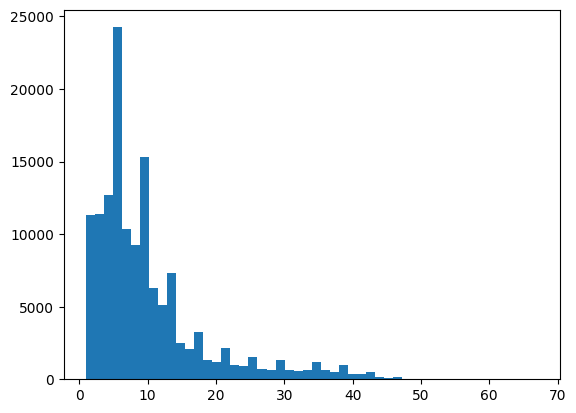

In [83]:
plt.hist([len(text) for text in X_train], bins=50)
plt.show()

In [84]:
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### Sequential API

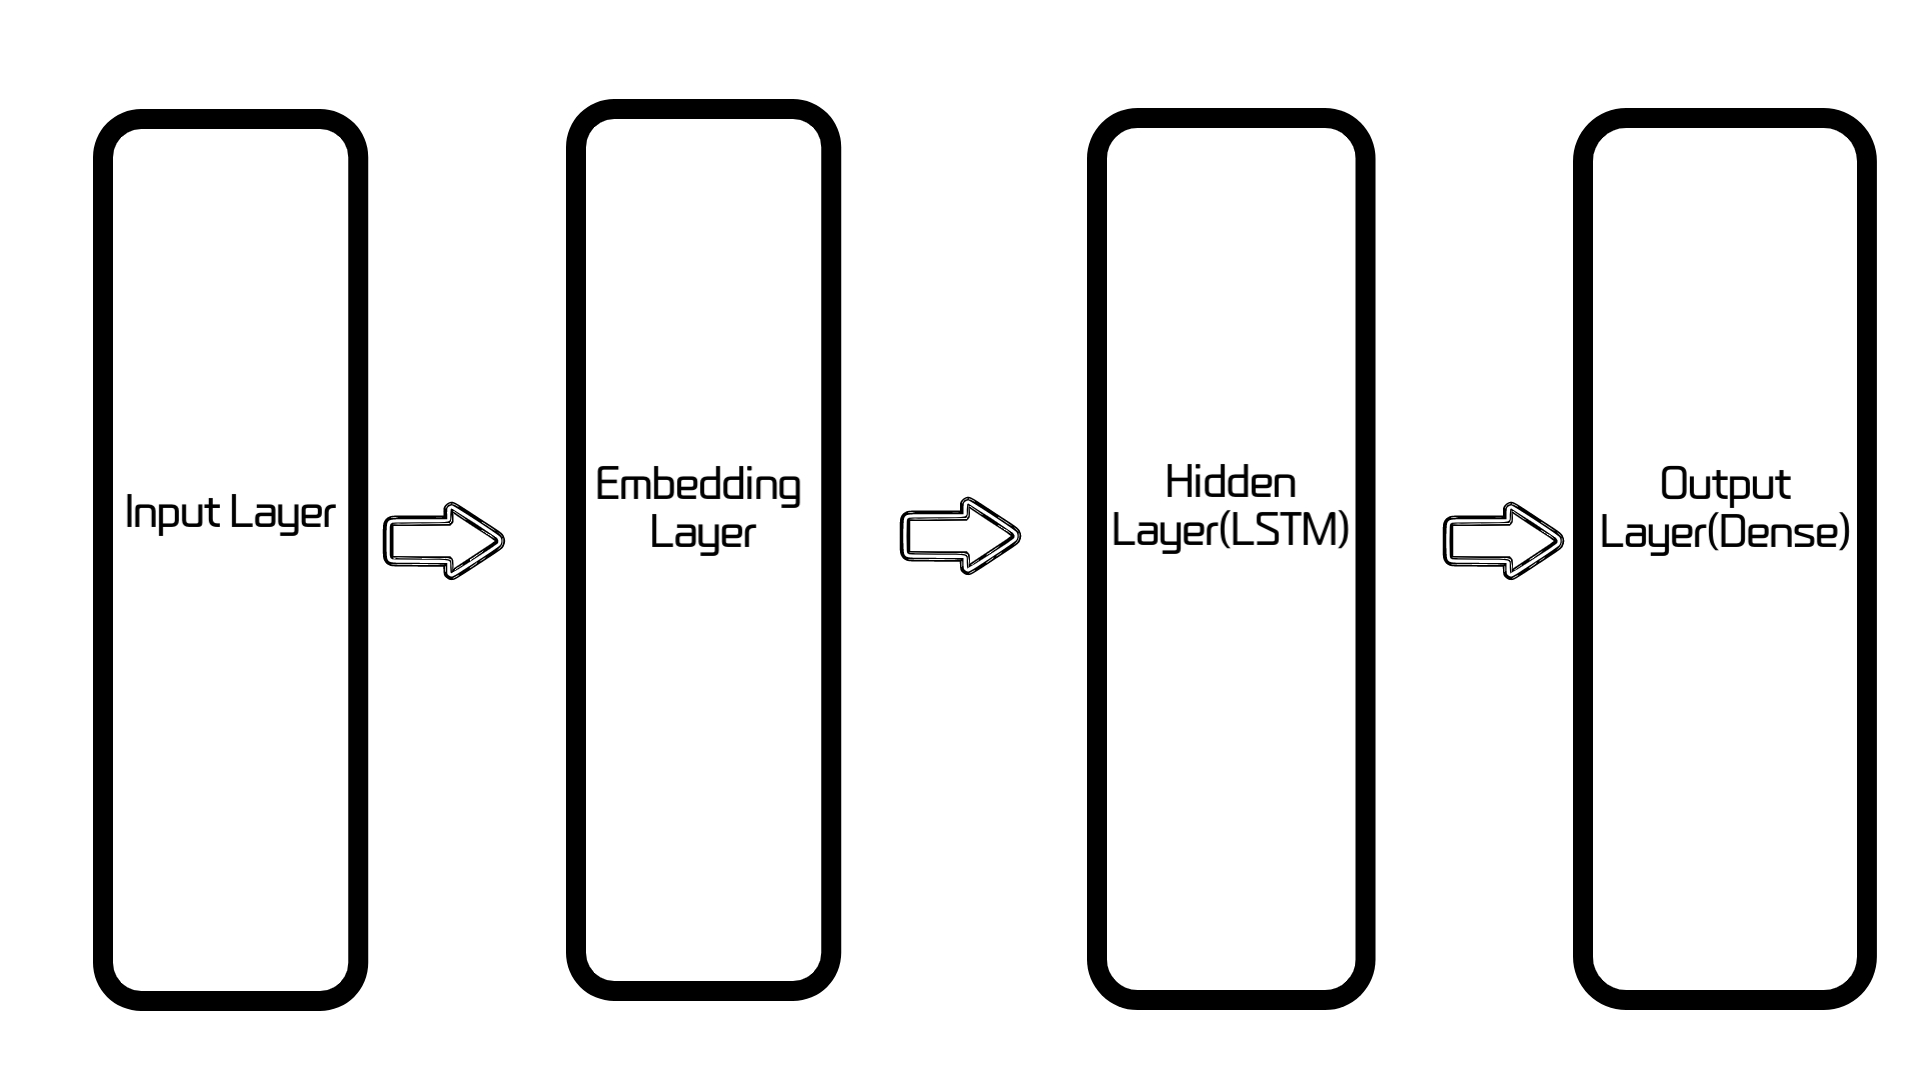

In [91]:
# binary classification
input_len = 100
hidden_unit = 128

model = Sequential()
model.add(Embedding(vocab_size, input_len))
model.add(LSTM(hidden_unit))
model.add(Dense(1, activation='sigmoid'))

#### Functional API

In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [87]:
input = Input(shape=(input_len,))
embed = Embedding(vocab_size, input_len)(inputs)
hidden = LSTM(hidden_unit)(embed)
output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=input, outputs=output)

#### Subclassing API

In [88]:
import tensorflow as tf

In [89]:
class NaverSentAnalysis(tf.keras.Model):
  def __init__(self):
    super(NaverSentAnalysis, self).__init__()
    self._vocab_size = vocab_size
    self._input_len = input_len
    self._hidden_unit = hidden_unit
    self.embed_layer = tf.keras.layers.Embedding(self._vocab_size, self._input_len)
    self.h = LSTM(self._hidden_unit)
    self.d = Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.embed_layer(x)
    x = self.h(x)
    return self.d(x)

#### compile and train

In [98]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('train_model.keras', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/10
1736/1736 [==============================] - ETA: 0s - loss: 0.2888 - acc: 0.8819
Epoch 1: val_loss improved from -inf to 0.40527, saving model to train_model.h5
1736/1736 [==============================] - 53s 29ms/step - loss: 0.2888 - acc: 0.8819 - val_loss: 0.4053 - val_acc: 0.8231
Epoch 2/10
1736/1736 [==============================] - ETA: 0s - loss: 0.2666 - acc: 0.8931
Epoch 2: val_loss improved from 0.40527 to 0.40743, saving model to train_model.h5
1736/1736 [==============================] - 32s 18ms/step - loss: 0.2666 - acc: 0.8931 - val_loss: 0.4074 - val_acc: 0.8210
Epoch 2: early stopping


In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         137122400 
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 137239777 (523.53 MB)
Trainable params: 137239777 (523.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### validation

In [104]:
loaded_model = load_model('train_model.keras')

In [105]:
loaded_model.evaluate(X_test, y_test)[1]

1500/1500 [==============================] - 6s 3ms/step - loss: 0.3863 - acc: 0.8358


0.8358171582221985

#### predict

In [106]:
def predict(text):
  stopwords = get_stopwords()

  text = re.sub(r"[^가-힣]", "", text)
  text = okt.morphs(text, stem=True)
  text = [word for word in text if not word in stopwords]
  encoded_text = tokenizer.texts_to_sequences([text])
  padded_text = pad_sequences(encoded_text, maxlen = max_len)
  score = float(model.predict(padded_text))
  if score > 0.5:
    print("긍정 리뷰입니다.")
  else:
    print("부정 리뷰입니다.")

example = input()
predict(example)

이 영화 재밌다
1/1 [==============================] - 0s 358ms/step
긍정 리뷰입니다.
